# Quantized transfer learning

In [23]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import torch 
import torchvision
from torchvision import transforms, datasets

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16, shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

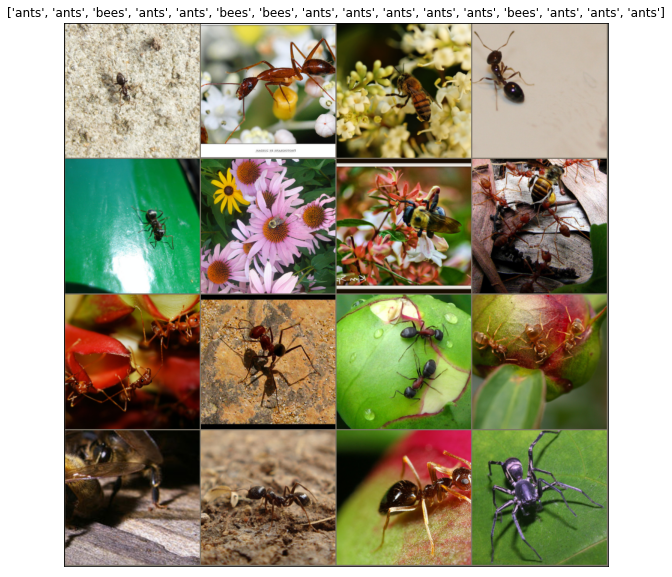

In [18]:
# visualize a few images
def imshow(inp, title=None, ax=None, figsize=(5,5)):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    if ax is None:
        fig, ax = plt.subplots(1, figsize=figsize)
    ax.imshow(inp)
    ax.set_xticks([])
    ax.set_yticks([])
    if title is not None:
        ax.set_title(title)

# get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
# make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=4)
fig, ax = plt.subplots(1, figsize=(10,10))
imshow(out, title=[class_names[x] for x in classes], ax=ax)

In [19]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, device="cpu"):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 20)
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        print()
    time_elpased = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elpased//60, time_elpased%60))
    print('Best val Acc: {:.4f}'.format(best_acc))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [20]:
def visualize_model(model, rows=3, cols=3):
    was_training = model.training
    model.eval()
    current_row = current_col = 0
    fig, ax = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
    
    with torch.no_grad():
        for idx, (imgs, lbls) in enumerate(dataloaders['val']):
            imgs = imgs.cpu()
            lbls = lbls.cpu()
            
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            
            for jdx in range(imgs.size()[0]):
                imshow(imgs.data[jdx], ax=ax[current_row, current_col])
                ax[current_row, current_col].axis('off')
                ax[current_row, current_col].set_title('predicted: {}'.format(class_names[preds[jdx]]))
                
                current_col += 1
                if current_col >= cols:
                    current_row += 1
                    current_col = 0
                if current_row >= rows:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [5]:
# training a custom classifier based on a quantized feature extractor
import torchvision.models.quantization as models
model_fe = models.resnet18(pretrained=True, progress=True, quantize=True)
num_ftrs = model_fe.fc.in_features
print(model_fe)

C:\Users\Bekhnam\anaconda3\lib\site-packages\torch\quantization\observer.py:122: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(
C:\Users\Bekhnam\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


QuantizableResNet(
  (conv1): QuantizedConvReLU2d(3, 64, kernel_size=(7, 7), stride=(2, 2), scale=0.028605546802282333, zero_point=0, padding=(3, 3))
  (bn1): Identity()
  (relu): Identity()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): QuantizableBasicBlock(
      (conv1): QuantizedConvReLU2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.016524722799658775, zero_point=0, padding=(1, 1))
      (bn1): Identity()
      (relu): Identity()
      (conv2): QuantizedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.04645531252026558, zero_point=75, padding=(1, 1))
      (bn2): Identity()
      (add_relu): QFunctional(
        scale=0.03447607904672623, zero_point=0
        (activation_post_process): Identity()
      )
    )
    (1): QuantizableBasicBlock(
      (conv1): QuantizedConvReLU2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.017180869355797768, zero_point=0, padding=(1, 1))
      (bn1): Iden

In [6]:
from torch import nn

def create_combined_model(model_fe):
    # isolate the feature extractor
    model_fe_features = nn.Sequential(
        model_fe.quant, # quantize the input
        model_fe.conv1,
        model_fe.bn1,
        model_fe.relu,
        model_fe.maxpool,
        model_fe.layer1,
        model_fe.layer2,
        model_fe.layer3,
        model_fe.layer4,
        model_fe.avgpool,
        model_fe.dequant, # dequantize the output
    )
    
    # create a new head
    new_head = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(num_ftrs, 2)
    )
    
    new_model = nn.Sequential(
        model_fe_features,
        nn.Flatten(1),
        new_head
    )
    
    return new_model

In [7]:
# the quantized part of the model can only be run on CPU
import torch.optim as optim
new_model = create_combined_model(model_fe)
new_model = new_model.to('cpu')

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(new_model.parameters(), lr=0.01, momentum=0.9)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Epoch 0/24
--------------------
train Loss: 0.4283 Acc: 0.8115
val Loss: 0.6150 Acc: 0.8105

Epoch 1/24
--------------------
train Loss: 0.7579 Acc: 0.8238
val Loss: 0.3329 Acc: 0.9346

Epoch 2/24
--------------------
train Loss: 0.3131 Acc: 0.9221
val Loss: 0.4385 Acc: 0.9216

Epoch 3/24
--------------------
train Loss: 0.5093 Acc: 0.8975
val Loss: 0.6774 Acc: 0.8627

Epoch 4/24
--------------------
train Loss: 0.6364 Acc: 0.9057
val Loss: 0.4392 Acc: 0.9412

Epoch 5/24
--------------------
train Loss: 1.1625 Acc: 0.8607
val Loss: 0.4540 Acc: 0.9477

Epoch 6/24
--------------------
train Loss: 0.8292 Acc: 0.9057
val Loss: 0.7857 Acc: 0.9020

Epoch 7/24
--------------------
train Loss: 0.5515 Acc: 0.9139
val Loss: 0.5328 Acc: 0.9346

Epoch 8/24
--------------------
train Loss: 0.2979 Acc: 0.9467
val Loss: 0.4851 Acc: 0.9477

Epoch 9/24
--------------------
train Loss: 0.5418 Acc: 0.9303
val Loss: 0.4703 Acc: 0.9412

Epoch 10/24
--------------------
train Loss: 0.5289 Acc: 0.9221
val Lo

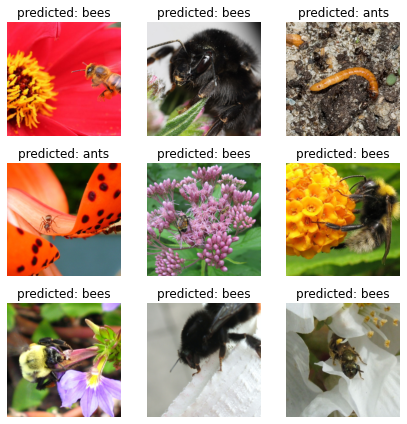

In [8]:
# train and evaluate
torch.cuda.empty_cache()
new_model = train_model(new_model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25, device='cpu')
visualize_model(new_model)
plt.tight_layout()

In [24]:
# finetuning the quantizable model
model = models.resnet18(pretrained=True, progress=True, quantize=False)
num_ftrs = model.fc.in_features

model.train()
model.fuse_model()

model_ft = create_combined_model(model)
model_ft[0].qconfig = torch.quantization.default_qat_qconfig

model_ft = torch.quantization.prepare_qat(model_ft, inplace=True)

In [26]:
for param in model_ft.parameters():
    param.requires_grad = True

model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.1)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.3)

model_ft_tuned = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25, device=device)


Epoch 0/24
--------------------


RuntimeError: DataLoader worker (pid(s) 6688, 10496, 14228, 7956) exited unexpectedly

In [ ]:
from torch.quantization import convert
model_ft_tuned.cpu()
model_quantized_and_trained = convert(model_ft_tuned, inplace=False)
visualize_model(model_quantized_and_trained)
plt.ioff()
plt.tight_layout()
plt.show()